<a href="https://colab.research.google.com/github/venkat2ram/Python/blob/master/Chapter3_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the mnist data from sklearn data sets.

In [0]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')

fetching the data from dataset.

In [2]:
X,y=mnist['data'],mnist['target']

print(X.shape,y.shape)

(70000, 784) (70000,)


Displaying a digit in plot.

In [0]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

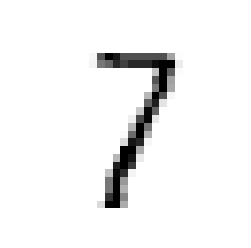

'2'

In [4]:
some_digit = X[36012]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36009]

Split the sets into traing and test sets.

In [0]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [0]:
import numpy as np
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

First let's train for the data with digit 5.

In [0]:
y_train_5=(y_train=='5')
y_test_5=(y_test=='5')

Train the Stochastic gradient classifier.

In [8]:
from sklearn.linear_model import SGDClassifier 
SGDC=SGDClassifier(random_state=42)
SGDC.fit(X_train,y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
SGDC.predict([some_digit])

array([False])

Perform cross validation on the training dataset.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
  cln=clone(SGDC)
  X_fold_train=X_train[train_index]
  y_fold_train=y_train_5[train_index]
  X_fold_test=X_train[test_index]
  y_fold_test=y_train_5[test_index]
  cln.fit(X_fold_train,y_fold_train)
  y_pred=cln.predict(X_fold_test)
  n_pred=sum(y_pred==y_fold_test)
  print(n_pred/len(y_fold_test))
  
  
  

0.96705
0.9664
0.95095


Now perform cross validation using cross_val_score() function.


In [0]:
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(SGDC,X_train,y_train_5,cv=3,scoring='accuracy')

In [12]:
cvs

array([0.96705, 0.9664 , 0.95095])

We can not depend on The accuracies. If our model predicts eevery thing ngative we will get accuracy as 90%. This is because only 10% of all the records in dataset are of digit 5.

So we need a better way to check if the predictions are actually acurate. For this compare predict set with target data in data set using confusion matrix.

In [0]:
y_t=SGDC.predict(X_train)

In [14]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train_5,y_t)
cm

array([[54460,   119],
       [ 2646,  2775]])

calculate Precision and recall using above numbers.

In [15]:
tn=cm[0,0]
fp=cm[0,1]
fn=cm[1,0]
tp=cm[1,1]
print(tn,fn,fp,tp)
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print('Precision=',precision)
print('Recall=',recall)


54460 2646 119 2775
Precision= 0.9588804422944022
Recall= 0.5118981737686774


Now calculate precision and recall using scikit learn.

In [16]:
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_t,y_train_5))
print(recall_score(y_t,y_train_5))

0.5118981737686774
0.9588804422944022


Both are matching. Now calculate the F1 score. f1= 2 / ( (1/precision)+(1/recall))

In [17]:
f1= 2 / ( (1/precision)+(1/recall))
print(f1)

0.6674684305472038


Now get the f1 score using sklearn.

In [18]:
from sklearn.metrics import f1_score
f1_score(y_t,y_train_5)

0.667468430547204

You can compromise on either recall or precision to improve the other. This is by increasing or decreasing the threshold of the classification. Threshold is nothing but a value used to decide whether an example is positive or negative. 
For this, you need to get the putput of the decision function of your classifier instead of predictions. like below. And then use precision_recall_curve to check the graph.

In [0]:
y_scores=SGDC.decision_function(X_train)

In [0]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,threshold= precision_recall_curve(y_train_5,y_scores)

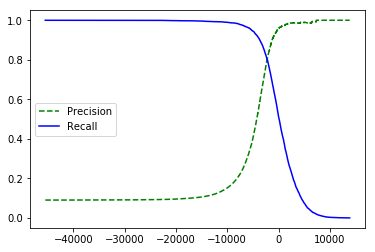

In [21]:
import matplotlib.pyplot as plt
plt.plot(threshold,precisions[:-1],'g--',label='Precision')
plt.plot(threshold,recalls[:-1],'b-',label='Recall')
plt.legend()
plt.show()

This clearly shos that at threshold 0 the precision and recall are at relative high. So now establish relation between precisiona and recall.

No handles with labels found to put in legend.


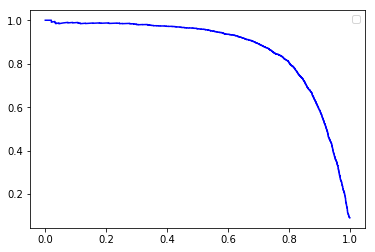

In [22]:
plt.plot(recalls[:-1],precisions[:-1],'b-')
plt.legend()
plt.show()

Recall is actually about how many positive values are classified as positives i.e) true positives. Now we need to see if the threshold is set to high, how many actual negatives are classified as positives(false positives). Use roc_curve for these details.

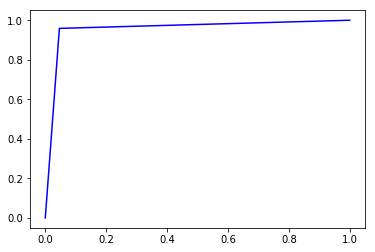

In [23]:
from sklearn.metrics  import roc_curve
fpr,tpr,thresholds=roc_curve(y_t,y_train_5)
plt.plot(fpr,tpr,"b-")
plt.xlabel='False positive rate'
plt.ylabel='True positive rate'

plt.show()

There is tradeoff identified. When true positive rate increased, false positives are increased. 

Area under curve(AUC) is usally used to measure the ROC curve's outcome. If area under curve is 1, the model is perfect. a random classifier will have 0.5 AUC.Below is how we calculate AUC.

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9697089247746529

The above score shows good result. But ROC curve is not dependable if the positive class is rare. So we should go with Precision-Recall curve(PR Curve).

**Random forests:**

Lets train the classifier using Random forests and check the performance.

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
forest_clf=RandomForestClassifier(random_state=42)
y_proba_forest=cross_val_predict(forest_clf,X_train,y_train_5,method='predict_proba')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


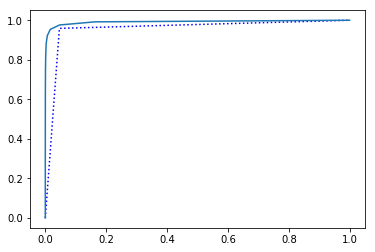

In [38]:
y_scores_forest=y_proba_forest[:,1]
fpr_forest,tpr_forest,threshold_forest=roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr,tpr,'b:')
plt.plot(fpr_forest,tpr_forest)
plt.show()

In [39]:
roc_auc_score(y_train_5,y_scores_forest)

0.9920465776979488

This clearly shows that random forest has better AUC score. Now check the precision recall curve.

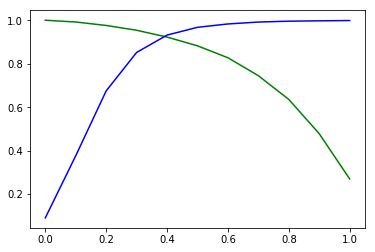

In [46]:
precisions_forest,recalls_forest,threshold_forest= precision_recall_curve(y_train_5,y_scores_forest)
plt.plot(threshold_forest,recalls_forest[:-1],'g-',label='Recall')
plt.plot(threshold_forest,precisions_forest[:-1],'b-',label='Precision')
plt.show()

In [54]:
y_scores_forest>0.5


array([False, False, False, ..., False,  True, False])

In [55]:

print(precision_score(y_scores_forest>0.5,y_train_5))
print(recall_score(y_scores_forest>0.5,y_train_5))

0.8273381294964028
0.9829059829059829
